# Optical Image Crystal Growth Rate Calculator
This notebook is used to find areal and facet growth rates for single crystals from optical microscopy images. The data is assumed to be h5py files but the functions can be used once images (as 2D float32 arrays), timestamps, and a scale are fed in.

## Useful imports

In [1]:
import hyperspy.api as hs                 # hyperspectral data processing and some useful image viewing
import h5py                               # to handle .h5 files
from matplotlib import pyplot as plt      # Plotting
import numpy as np                        # Maths
import cv2                                # Image analysis
from os import walk                       # To get filepaths automatically
from natsort import natsorted             # To easily resort file order
from datetime import datetime             # For easily parsing timestamps
import warnings
warnings.filterwarnings("ignore")         # Attempt to remove some unnecessary pyplot warnings
import optical_image_functions as oif

## Folder Selection

In [2]:
folder = r'C:\Users\es758\Documents\Python Scripts\Mini 1\Reflection data subset\\'

Can inspect the structure of the files by running the below code.

In [3]:
# fpaths = oif.get_filepaths(folder)
# fpath=fpaths[0]
# oif.get_h5py_contents(fpath)

## Image Data Extraction

In [4]:
# Some base code for the below is all in test_notebook
# Plot times by using a to be made plotting function?
# Plot specific image function?
# Plot hs time series function?
# backend maplotlib chooser like George?

Extracting images and timestamps using suggested function which truncates series if a large discontinuity in timestamp is detected.

In [5]:
ts, images, pixel_size = oif.get_data_h5py(folder)

In [6]:
%matplotlib qt
s = hs.signals.Signal2D(images)
s.plot()

In [7]:
# plot contours could be adapted from test notebook too to incldue scale etc.
# should plot areas too to check if preprocessing working
# Need to make plotting functions to investigate quality of pre-processing for purpose.
# should I provide a manual contour selection too to allow checking of estimate? Or can just use scale to say how much image frame is.

In [8]:
# inspecting code probably would use some of
def plot_contours(cnts,im,title=None):
    """ Takes contours and an image, and plots them both"""
    plt.figure()
    cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    for i in range(len(cnts)):
        plt.scatter(cnts[i][:,0][:][:,0],cnts[i][:,0][:][:,1],s=2,color=cols[i%len(cols)],alpha=0.4)
        plt.imshow(im,cmap='gray')
    if title != None:
        plt.title(title,fontsize=15)
    #plt.axis('off')
    row, col = im.shape
    plt.xlabel(str(col*pixel_size))
    plt.ylabel(str(row*pixel_size))
    plt.show()
    

# %matplotlib qt
# i=22
# image=[images[i]]
# contour_sets, area_sets, perim_sets = get_contour_data(image)
# plot_contours(contour_sets[0], get_binary(image[0]))

## Crystal Area by Contour Extraction
Contour extraction for area estimation assumes a single large crystal growing entirely in the field of view. Be careful of image data containing multiple crystals and those where crystals are partly out of the field of view.

### Image Pre-Processing
Should check if working for data set of interest and tailor accordingly.

In [9]:
def get_binary(im):
    """
    Suggested image pre-processing to produce a binary that can get good estimates of crystal area from an image. 
    @param im: a 2D float32 array
    @return binary: a 2D array of uint8 values of 1s and 0s. 
    Pre-processing can heavily influence the quality of the area estimates and should be tailored to specific sets of images.
    Use plotting functions I have made to investigate 
    Things to consider include:
        Changing the order or presence of image pre-processing operations
        Change the size of kernels from the default values suggested in optical_image_functions
        Avoid causing area values to collapse by making the edge around the crystal discontinuous
        Avoid having a binary that effectively has a shell in the outline
    Use https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html as a guide for what some of the operations do.
    Note that some of the image examples may not apply as expected depending on at which stage the operations are applied (e.g. opening base image rather than the threshold or sobel).
    """
    im1 = oif.blur_image(im)
    im1=oif.close_image(im1, 8) # changing the kernel size to 8 was found to improve the end binary in this case.
    im1=oif.open_image(im1)
    im1=oif.sobel_2D(im1)
    binary=oif.threshold_image(im1)
    return binary

In [10]:
binary_images=[get_binary(im) for im in images]

In [11]:
%matplotlib qt
s = hs.signals.Signal2D(binary_images)
s.plot()

### Contour Extraction

In [12]:
contour_sets, area_sets, perim_sets = oif.get_contour_data(binary_images)

From contour data, extract the most suitable data and clean it for growth rate estimation.

In [13]:
def extract_best_contour_data(contour_sets, area_sets, perim_sets):
    """
    Suggested function for extracting the most relevant contour data. Currently just takes the set of data belonging to the contour with the biggest area. The logic being that the largest contour is
    most likely to be around the most interesting crystal growing entirely within the view of the camera. The area was used instead of the permiter as it is more stable.
    @param contour_sets: an array containing sets of contours for each image.
    @param area_sets: an array containing sets (stored in arrays) of areas (floats) corresponding to contours identified in each image.
    @param perim_sets: an array containing sets (stored in arrays) of perimeters (floats) corresponding to contours identified in each image.
    @return best_contours, best_areas, best_perims
    
    Possible future changes:
    - Make more general so can pick out the contour of a single crystal entirely within frame despite other features of the image
    - Throw an error if this isn't possible or a single crystal isn't present
    """
    best_contours = []
    best_areas = []
    best_perims = []
    for i in np.arange(len(contour_sets)):
        criterion = np.max(area_sets[i]) # Just takes the biggest contour
        best_areas.append(criterion)
        j = area_sets[i].index(criterion)
        best_contours.append(contour_sets[i][j])
        best_perims.append(perim_sets[i][j])
    return best_contours, best_areas, best_perims

def clean_area_data(contour_series, area_series, time_series, step_factor=100):
    """
    Suggested function for processing crystal area data before extracting growth rates. It checks if there is a large step change in the crystal being tracked. If the estimate recovers, it replaces the
    faulty data with NaN. If the estimate does not recover by the next entry, it truncates the series in the assumption that the failure is due to the crystal reaching the edge of the field of view which
    causes the contours to freak out a bit.
    @param contour_series: an array of contour data for each time step
    @param area_series: an array of area estimates (floats) for each contour
    @param time_series: an array of timestamps (floats) for each image
    @param step_factor: factor determining the sensitivity of the detector to a step change in area
    @return cleaned_contour_series, cleaned_area_series, cleaned_time_series
    
    Possible future changes:
    - Make more lenient in truncating condition. Justified for now as possible to remove problems with image pre-processing but more flexibility may be useful for larger data sets.
    """
    cleaned_area_series = []
    index_list = np.arange(len(area_series))
    NaNcounter=0 # Counter used to track how many NaNs in total
    for i in index_list:
        if i == 0 or i == index_list[-1]:
            cleaned_area_series.append(area_series[i])
        elif i == 1:
            cleaned_area_series.append(area_series[i])
         # Check if something has gone wrong with area estimate
        elif abs(area_series[i]-cleaned_area_series[i-1]) > step_factor*abs(cleaned_area_series[i-1]-cleaned_area_series[i-2]):
            # Check if area value collapsed probably without recovery, likely due to crystal reaching edge of frame
            if area_series[i+1] < cleaned_area_series[i-1]: # Perhaps it is a bit harsh, but checks by seeing if 2 in a row a problem
                break
            # If next entry is fine, replace with a NaN and move on
            else:
                cleaned_area_series.append(np.NaN)
                NaNcounter += 1
        # If everything is fine, just add the area to the cleaned list
        else:
            cleaned_area_series.append(area_series[i])   
    cleaned_time_series = time_series[:len(cleaned_area_series)]
    cleaned_contour_series = contour_series[:len(cleaned_area_series)]
    if NaNcounter > len(cleaned_area_series)*0.33:
            print("More than a third of area data entries in cleaned range are dodgy")
    return cleaned_contour_series, cleaned_area_series, cleaned_time_series

In [14]:
best_contours, best_areas, best_perims = extract_best_contour_data(contour_sets, area_sets, perim_sets)
cleaned_contour_series, cleaned_area_series, cleaned_time_series = clean_area_data(best_contours, best_areas, ts)

In [15]:
i=8
plot_contours([cleaned_contour_series[i]],binary_images[i],title=None)

Convert area by pixel into better units and calculate growth rates in µm^2/s.

In [16]:
crystal_area_series = np.array(cleaned_area_series)*pixel_size*pixel_size
crystal_time_series = cleaned_time_series
crystal_area_growth_rates = oif.extract_area_growth_rate(crystal_area_series, crystal_time_series) 

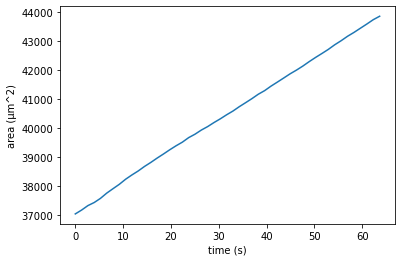

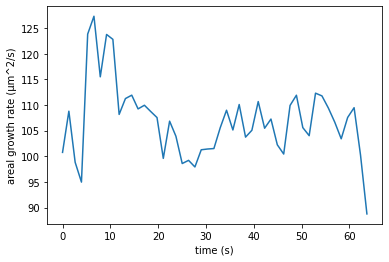

In [17]:
# Could try add to plot marker if NaN, obviously none here rn
%matplotlib inline
plt.figure()
plt.plot(crystal_time_series, crystal_area_series)
plt.xlabel("time (s)")
plt.ylabel("area (µm^2)")
plt.show()
plt.figure()
plt.plot(crystal_time_series, crystal_area_growth_rates)
plt.xlabel("time (s)")
plt.ylabel("areal growth rate (µm^2/s)")
plt.show()

Estimate areal growth rate by linear fit. 

In [18]:
from scipy.optimize import curve_fit

x = crystal_time_series
y = crystal_area_series

def fit_func(x, a, b):
    return a*x + b

params = curve_fit(fit_func, x, y)

[a, b] = params[0]
print(a, "µm^2/s")

106.6900567070083 µm^2/s


## Facet Growth Rate

Funnily enough, should be fine for crystal not entirely being in frame initially. Will probably have trouble if more than one crystal though due to mixed signals. Might have to find way of segmenting etc in future?

In [19]:
def get_outline(im):
    """
    Advisable to do this processing and sobel filter before rotating image as the blank data is otherwise highlighted at the border with the actual data.
    """
    im1 = oif.blur_image(im)
    im1=oif.close_image(im1, 8) # changing the kernel size to 8 was found to improve the end sobel filtered image for the starting data.
    im1=oif.open_image(im1)
    sobel=oif.sobel_2D(im1)
    return sobel

def rotate_image(im, angle):
    """
    Rotates an image about its centre by a specified angle.
    Note that the rotation keeps the image the same size so data in the corners will be out of frame and the new corners will be black from no data.
    note that if I rotate before taking sobel filter of image, the black corners of no data will stand out very brightly from the sobel.
    """
    row, col = im.shape
    image_centre = tuple(np.array([row, col])/2)
    rot_mat = cv2.getRotationMatrix2D(image_centre, angle, 1.0)
    result = cv2.warpAffine(im, rot_mat, (col, row), flags=cv2.INTER_LINEAR) # warpAffine takes shape tuple in reverse order to standard
    return result

def onedimify(im):
    """
    Apply image preprocessing to avoid splintered peaks.
    """
    #row, col = im.shape
    im_1D_av = []
    for row in im:
        im_1D_av.append(np.average(row))
    return im_1D_av

def find_alignment(im, step_degree=1):
    angles = np.arange(0, 180+step_degree, step_degree) # if only allow 90 degrees won't necessarily find the alignement with the 
    # longest face because it doesn't rotate back, I've tried. Need to let it do 180 degrees.
    # better to do this than not know which it is finding? Or maybe if end up extracting growth rate both directions then doesn't matter
    biggest_signals = []
    for angle in angles:
        rotated_image = rotate_image(im, angle)
        onedim = onedimify(rotated_image)
        biggest_signals.append(np.max(onedim))
    best_alignment = angles[biggest_signals.index(np.max(biggest_signals))]
    return best_alignment

### Manual Facet Growth Rate Extraction

There are a couple of weird sign flips in here but trust the scripts, had to account for having weirdness with y axis.

In [20]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2=[0,1]):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
            
            
            Changed now to give degrees
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return (np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))/np.pi)*180

def manual_detection(im,max_shapes=20):
    """ 
    Manually click out a line
    """
    # Show image
    plt.imshow(im,cmap='Greys_r')
    plt.axis('off')
    all_points = []
    all_s = []
    # Get user input
    for i in range(max_shapes):
        plt.title('Line %i \n Left click to add (up to 2) points \
        \n Direction assigned will be from first point to second \
        \n Right click for next line \
        \n Middle click to remove a point (Use when zooming) \
        \n Finish by right clicking without adding points' %i,fontsize=8)
        points = plt.ginput(n=2, timeout=0, show_clicks=True,mouse_stop=3,mouse_pop=2)
        if points == []:
            break
        else:
            all_points.append(points)

            s = np.array(points)
            all_s.append(s)        
    plt.close()
        

    return all_s

def rotate(origin, point, angle):
    """
    Rotate a point anticlockwise by a given angle around a given origin.
    The angle should be given in degrees.
    """
    ox, oy = origin
    px, py = point
    angle=angle*np.pi/180 # convert to radians from degrees
    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy

In [21]:
def image_rotation_by_manual_line(im, line_points):
    """
    Possible all my sign flips are solving a problem they create, but I know it works right now.
    
    could improve by using find alignment with a crop box or something to make line perpendicular to a selected facet in this function or maybe manual detection.
    """
    line=line_points[1]-line_points[0]
    line[1]=-line[1] # weird sign flip that works out
    angle=angle_between(line)
    if line_points[0][0]>line_points[1][0]: # accounts properly for sign rotation angle needs to be to align with vertical
        angle=-angle
        
    row, col = im.shape
    image_centre = tuple(np.array([row, col])/2)
    
    rotated_image = rotate_image(im, angle)
    rotated_line_points=[rotate(image_centre, point, -angle) for point in line_points] # Need -angle for sign convention reasons, it works
    
    return np.array(rotated_image), np.array(rotated_line_points), angle

In [22]:
%matplotlib qt
test_image=images[0].copy()
test_image=get_outline(test_image)
line_points=(manual_detection(test_image))[0]
rotated_image, rotated_line_points, angle = image_rotation_by_manual_line(test_image, line_points)

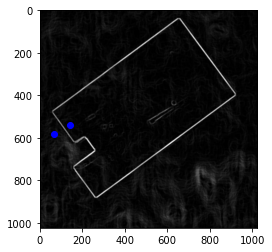

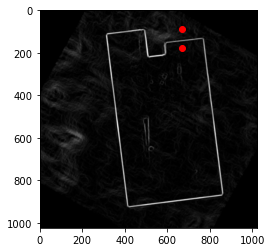

In [23]:
%matplotlib inline
plt.imshow((test_image), cmap='Greys_r')
plt.scatter(line_points[0][0],line_points[0][1], color="blue")
plt.scatter(line_points[1][0],line_points[1][1], color="blue")
plt.show()
plt.imshow(rotated_image, cmap='Greys_r')
plt.scatter(rotated_line_points[0][0], rotated_line_points[0][1], color="red")
plt.scatter(rotated_line_points[1][0], rotated_line_points[1][1], color="red")
plt.show()

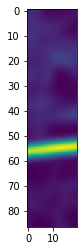

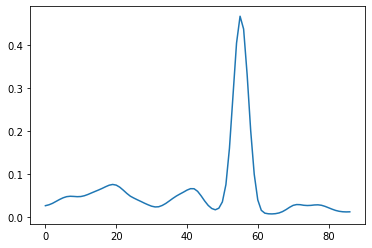

In [24]:
%matplotlib inline
# round them to nearest integer
rotated_line_points=np.rint(rotated_line_points)
rotated_line_points=rotated_line_points.astype(int)

# for now best can do is just assume straight line

x_pixel=rotated_line_points[0][0]
y_pixel_0=rotated_line_points[0][1]
y_pixel_1=rotated_line_points[1][1]

# crop image
cropped=rotated_image[y_pixel_1:y_pixel_0, x_pixel-10:x_pixel+10] #way rotation works means should always be in the right order due to direction of arrow
plt.imshow(cropped)
plt.show()


plt.plot(onedimify(cropped))
plt.show()

### Automatic Facet Growth Rate Extraction

144


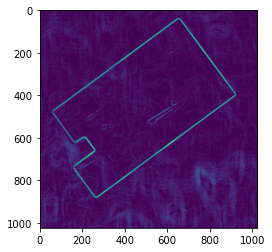

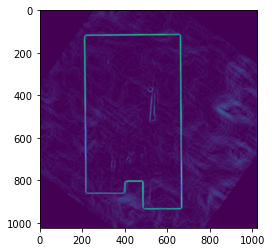

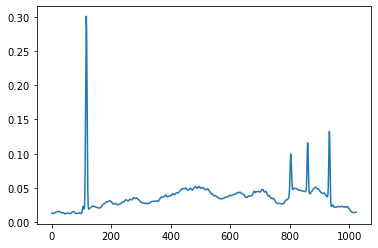

In [25]:
%matplotlib inline
image_test=images[0].copy()
sobel=get_outline(image_test)
print(find_alignment(sobel, 1))
plt.imshow(sobel)
plt.show()
plt.imshow(rotate_image(sobel, 54))
plt.show()
plt.plot(onedimify(rotate_image(sobel, 54)))

In [26]:
rotated_images = []
onedimified_images=[]
for im in images:
    sobel=get_outline(im)
    rot_sobel = rotate_image(sobel, 54)
    onedimified_images.append(onedimify(rot_sobel))
    rotated_images.append(rot_sobel)
print("done")

done


In [35]:
%matplotlib qt
s = hs.signals.Signal2D(rotated_images)
s.plot()

In [28]:
%matplotlib qt
onedim = hs.signals.Signal1D(onedimified_images)
onedim.plot()

find_peaks1D_ohaver(xdim=None, slope_thresh=0, amp_thresh=None, subchannel=True, medfilt_radius=5, maxpeakn=30000, peakgroup=10, parallel=None, max_workers=None)

‘slope_thresh’ and ‘amp_thresh’, control sensitivity: higher values will neglect broad peaks (slope) and smaller features (amp), respectively.

peakgroup is the number of points around the top of the peak that are taken to estimate the peak height. For spikes or very narrow peaks, set peakgroup to 1 or 2; for broad or noisy peaks, make peakgroup larger to reduce the effect of noise.

  0%|          | 0/1 [00:00<?, ?it/s]

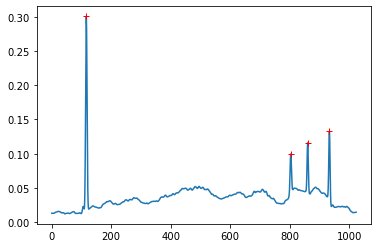

[116.0, 803.0, 860.0, 933.0]


In [29]:
coordinates = np.arange(len(onedimified_images[0]))
coordinates_micrometres = coordinates*pixel_size

%matplotlib inline

a= onedimified_images[0]

s = hs.signals.Signal1D(a)
peaks = s.find_peaks1D_ohaver(xdim = coordinates_micrometres, peakgroup=2,slope_thresh=0.001) # not sure if xdim is doing anything or I have implemented right as positions still to be in index
# and therefore pixel rather than distance.

plt.plot(a)
position = [i[0] for i in peaks[0]]
height = [i[1] for i in peaks[0]]
plt.plot(position, height, 'r+')
plt.show()

print(position)

In [30]:
coordinates_micrometres

array([0.00000e+00, 3.25000e-01, 6.50000e-01, ..., 3.31825e+02,
       3.32150e+02, 3.32475e+02])

In [31]:
%%capture 
# Just here to stop the output being spammed with progress bars.
max_heights = []
max_positions = []

coordinates = np.arange(len(onedimified_images[0]))
coordinates_micrometres = coordinates*pixel_size

for Onedim_Im in onedimified_images:
    s = hs.signals.Signal1D(Onedim_Im)
    peaks = s.find_peaks1D_ohaver(xdim = coordinates_micrometres, peakgroup=2,slope_thresh=0.001)
    positions = [i[0] for i in peaks[0]] # Note that is by pixel index
    heights = [i[1] for i in peaks[0]] # Will be stronger for a larger facet
    max_height = np.max(heights)
    max_heights.append(max_height)
    max_position = positions[heights.index(max_height)]
    max_positions.append((max_position+0.5)*pixel_size) # not a perfect conversion but sets position by midpoint of pixel.


Text(0, 0.5, 'position (µm)')

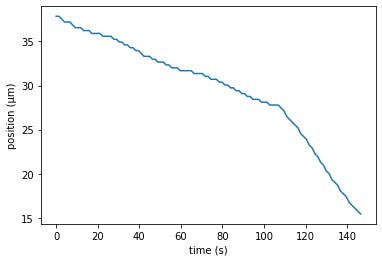

In [32]:
plt.plot(ts, max_positions)
plt.xlabel("time (s)")
plt.ylabel("position (µm)")

Got to be careful of facet growing off screen. Don't think that happens in my example data but I will make sure.

In [33]:
for i in max_positions:
    if i == pixel_size*0.5:
        print("reached extent")
    if i == pixel_size*(-0.5+len(onedimified_images[0])):
        print("reached extent")

Text(0, 0.5, 'facet growth rate (µm/s)')

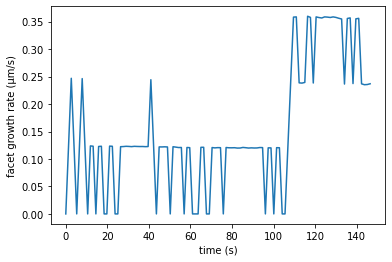

In [34]:
%matplotlib inline

facet_growth_rates=[]

for i in np.arange(len(max_positions)):
    if i == 0:
        gro = (max_positions[1]-max_positions[0])/(ts[1]-ts[0])
    elif i == len(max_positions)-1:
        gro = (max_positions[-1]-max_positions[-2])/(ts[-1]-ts[-2])
    else:
        gro = (max_positions[i+1]-max_positions[i-1])/(ts[i+1]-ts[i-1])
    facet_growth_rates.append(abs(gro))
    
plt.plot(ts, facet_growth_rates)
plt.xlabel("time (s)")
plt.ylabel("facet growth rate (µm/s)")